<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports
!wget "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/utils.py"
!pip install -i https://pypi.gurobi.com gurobipy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy
import cvxopt
import itertools
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from utils import DataLoader
from IPython.display import display

cvxopt.solvers.options['show_progress'] = False

--2023-03-09 20:04:17--  https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/utils.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/YI-CHENG-SHIH645/ML/raw/master/utils.py [following]
--2023-03-09 20:04:17--  https://github.com/YI-CHENG-SHIH645/ML/raw/master/utils.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML/master/utils.py [following]
--2023-03-09 20:04:17--  https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

In [2]:
# create a toy dataset

income = [30, 55, 63, 35, 28, 140, 100, 95, 64, 63]
credit_score = [40, 30, 30, 80, 100, 30, 30, 90, 120, 150]
label = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
col_names = ['income', 'credit_score', 'label']

# create a 2d numpy array with dim = n x (m + 1)
data = np.array([income, credit_score, label]).T
data = pd.DataFrame(data, columns=col_names).astype(float)
data.head(7)

,income,credit_score,label
0,30.0,40.0,0.0
1,55.0,30.0,0.0
2,63.0,30.0,0.0
3,35.0,80.0,0.0
4,28.0,100.0,0.0
5,140.0,30.0,1.0
6,100.0,30.0,1.0


In [3]:
# 這些 functions 專為 toy dataset 設計

def get_best_line(w1, w2, b):
    x1 = np.linspace(0, 140, 10000)
    x2 = (b - w1 * x1) / w2
    
    # 只取第一象限的部分
    cond = x2 >= 0
    return x1[cond], x2[cond]

def plt_res(*args):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(x='income', y='credit_score', data=data,
                    style='label', markers={0: 'o', 1: 's'},
                    s=65, ax=ax)
    # 設定 x, y 要顯示的範圍
    ax.set_ylim(bottom=0, top=300)
    ax.set_xlim(left=0)

    # 如果有傳入參數，代表除了畫出點之外，還要畫出 decision boundary
    if len(args):
        w1, w2, b = args
        ax.plot(*get_best_line(w1, w2, b))
        ax.plot(*get_best_line(w1, w2, b+1), '--')
        ax.plot(*get_best_line(w1, w2, b-1), '--')
    plt.show()

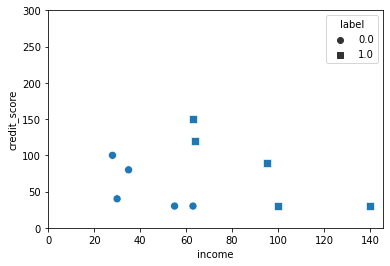

In [4]:
plt_res()

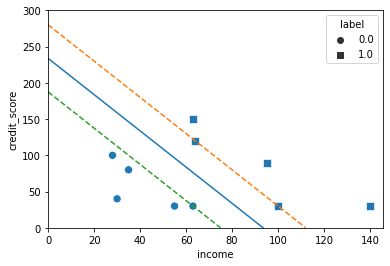

In [5]:
# 假設我們知道最優解，畫出來看看
w1, w2, b = 0.05405, 0.02162, 5.054
plt_res(w1, w2, b)

middle line: $w_1x_1 + w_2x_2 = b$ <br>
upper line: $w_1x_1 + w_2x_2 = b_U$ <br>
lower line: $w_1x_1 + w_2x_2 = b_L$ <br>
可以進一步設 $b_U = b+1, b_L = b-1$, 不會影響找到的線 <br>
設 upper & lower 間的寬度為 P <br>
可以推得 $P = \frac{b_U - b_L}{\sqrt{w_1^2 + w_2^2}} = \frac{2}{\sqrt{w_1^2 + w_2^2}}$ <br>
要最大化 P
>minimize $ w_1^2 + w_2^2 $ <br>
>under constraints: <br>
> $ w_1x_{k1} + w_2x_{k2} >= b+1 $ if $ x_k \in class_1$  <br>
$ w_1x_{k1} + w_2x_{k2} <= b-1 $ <br>

how to solve w1, w2, b?
> Quadratic Programming (QP) <br>

但是我們的問題並不像是 QP 的 standard form <br>
事實上將問題經轉換成 dual problem (會有一些額外的好處＆性質) 可以得 QP 的 standard form<br>
不過在此我們可以先把 primal 形式的問題給 gurobipy 幫我們找解即可

In [6]:
# 設定一個 gurobipy 的優化模型
def model_setup(data):
    model = gurobipy.Model()

    # 不顯示優化過程數據
    model.Params.OutputFlag = 0
    num_of_params = data.shape[1] # m+1

    # 依據給的 data 來加入參數
    params_name = ["x{}".format(i) for i in range(1, num_of_params)] + ['b']
    params = model.addVars(params_name)

    return model, params

Restricted license - for non-production use only - expires 2024-10-28
0.054 0.022 5.054


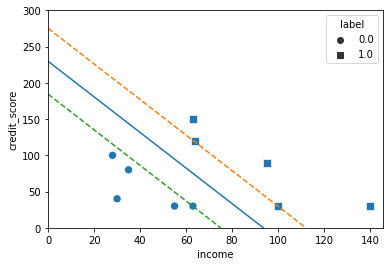

In [7]:
model, params = model_setup(data)
params_name = params.keys()

# 取出 class 1 的 x
coefs_1 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if coef[-1]]
model.addConstrs(params.prod(coefs_1[i]) >= params['b']+1 for i in range(len(coefs_1)))

# 取出 class 0 的 x
coefs_0 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if not coef[-1]]
model.addConstrs(params.prod(coefs_0[i]) <= params['b']-1 for i in range(len(coefs_0)))

model.setObjective(params['x1']**2 + params['x2']**2, gurobipy.GRB.MINIMIZE)
model.optimize()

w1, w2, b = (round(v.x, 3) for v in model.getVars())
print(w1, w2, b)
plt_res(w1, w2, b)

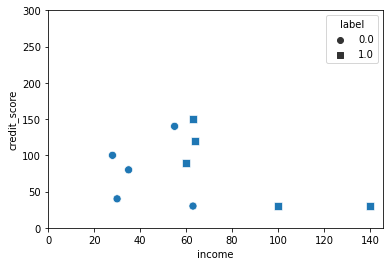

In [8]:
# hard margin 如何分以下資料？
data.loc[2-1, 'credit_score'] = 140
data.loc[8-1, 'income'] = 60

plt_res()

# 要能容許一些錯誤的存在 => soft margin

minimize $ w_1^2 + w_2^2 $ <br>
under constraints: <br>
 $ w_1x_{k1} + w_2x_{k2} >= b+1 - s_i $ if $ x_k \in class_1$  <br>
$ w_1x_{k1} + w_2x_{k2} <= b-1 + s_i$ o.w.<br>
where $s_i$ is a slack variable, $s_i$ $\geq$ 0

,C,w1,w2,b,mis_cls,path_width,violations
0,0.0100,0.0541,0.0216,5.0541,0.1,34.3536,2.8108
1,0.0010,0.0397,0.0122,3.3339,0.1,48.1785,3.3058
2,0.0005,0.0265,0.0100,2.5265,0.2,70.6114,4.7910
3,0.0003,0.0187,0.0057,1.7909,0.2,102.2153,5.7876
4,0.0002,0.0185,0.0033,1.6858,0.3,106.5540,5.9097


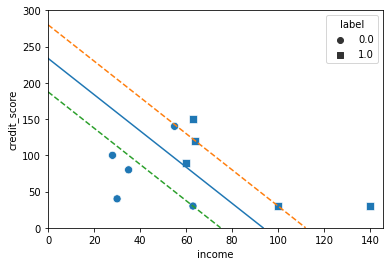

In [9]:
def soft_margin(C, data):
    model, params = model_setup(data)
    params_name = params.keys()
    coefs_1 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if coef[-1]]
    coefs_0 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if not coef[-1]]

    slack_variables = model.addVars(range(len(data)))

    model.addConstrs(params.prod(coefs_1[i]) >= params['b']+1 - slack_variables[i]
                     for i in range(len(coefs_1)))
    model.addConstrs(params.prod(coefs_0[i]) <= params['b']-1 + slack_variables[i+len(coefs_1)]
                     for i in range(len(coefs_0)))
    c_part = C * gurobipy.quicksum(slack_variables[i] for i in range(len(slack_variables)))
    sq_sum = gurobipy.quicksum(params[x]**2 for x in params_name[:-1])
    model.setObjective(c_part + sq_sum, gurobipy.GRB.MINIMIZE)
    model.optimize()

    wb = [v.x for v in params.values()]
    w, b = wb[:-1], wb[-1]
    predicted_b = data.iloc[:, :-1] @ np.array(w)
    mis_cls = ((predicted_b - b > 0).astype(int) != data.iloc[:, -1]).sum() / len(data)
    path_width = 2 / np.sqrt(sum(wn**2 for wn in w))
    violations = sum([(b+1)-pb if label else pb-(b-1) for pb, label in zip(predicted_b, data.iloc[:, -1]) if b-1 < pb < b+1])
    info = [wn for wn in w]
    info.extend([b, mis_cls, path_width, violations, model.ObjVal])

    return tuple(info)

C = [.01, .001, .0005, .0003, .0002]
cols_name = ['C', 'w1', 'w2', 'b', 'mis_cls', 'path_width', 'violations']
results = np.concatenate((np.array(C).reshape(-1, 1), np.array([soft_margin(c, data)[:-1] for c in C])), axis=1)
results = pd.DataFrame(results, columns=cols_name)
display(results.round(4))

w1, w2, b = results[results['C'] == 0.01][['w1', 'w2', 'b']].values[0]
plt_res(w1, w2, b)

0.054 0.022 5.054


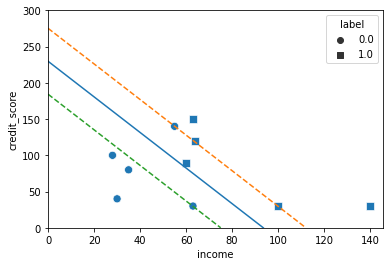

In [10]:
# 和 sklearn 的 SVC 比較一下 C = 0.01 時的結果，C會差0.5倍
m = SVC(kernel='linear', C=0.01/2, tol=1e-6).fit(data.iloc[:, :-1], data.iloc[:, -1])
w1, w2 = m.coef_[0].round(3)
b = -m.intercept_[0].round(3)
print(w1, w2, b)
plt_res(w1, w2, b)

SVC 裡有個參數 kernel (function)，那是什麼呢？ <br>
理解將 primal problem 轉換為 dual problem(等價於原問題) 的過程，即可認識到 kernel <br>利用 mercer's theorem，帶入不同 kernel funciton 使得我們的分類器具非線性能力 <br>

0.0541 0.0216 5.054


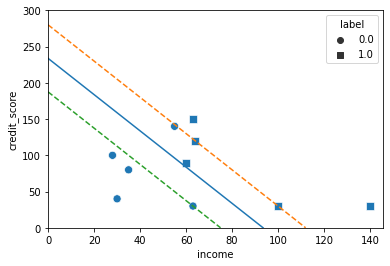

In [11]:
def rbf(x1, x2):
    return np.exp(-((x1 - x2)**2).sum(-1))

def find_kkt_multiplier(data, C=0, kernel='linear'):
    # 取標籤 array
    y = data.label.values

    # 把 0 換成 -1
    y = np.where(y==0, -1, y)

    # 取 features
    x = data.drop('label', axis=1).values

    # 資料個數
    n = len(x)

    # linear kernel => (n x m) @ (m x n) => data points 間的 similarity
    if kernel == 'linear':
        K = x @ x.T
    # 由 mercer's theorem 知 高維空間中的 data points 間的 similarity 
    # 可由 kernel function 代原始 data 計算
    elif kernel == 'rbf':
        K = np.zeros((n, n))
        for i, j in itertools.product(range(n), range(n)):
            K[i, j] = rbf(x[i], x[j])

    # 以下為推導結果
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(np.ones(n) * -1)
    
    G = np.diag(np.ones(n) * -1)
    h = np.zeros(n)
    if C:
        G = np.vstack([G, np.diag(np.ones(n))])
        h = np.hstack([h, np.ones(n) * C])
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(0.0)

    # 得 kkt multiplers
    multipliers = cvxopt.solvers.qp(P, q, G, h, A, b)['x']

    return np.ravel(multipliers), K

def get_wb(C):
    kkt, _ = find_kkt_multiplier(data, C=C)
    y = data.label.values
    y = np.where(y==0, -1, y)
    x = data.drop('label', axis=1).values

    # nx1 nx1 mxn
    w = (kkt * y * x.T).sum(1)
    intermediate_kkt_idx = np.where((kkt > 1e-6) & (C - kkt > 1e-8))[0]
    y_sv = y[intermediate_kkt_idx]
    x_sv = x[intermediate_kkt_idx]
    # 只有 support vector 在線上，故只用 sv 的部分
    b = (y_sv - x_sv @ w).mean()
    w1, w2 = w

    return w1, w2, -b

# 解 dual problem 的 QP standard form 的結果
w1, w2, b = get_wb(0.01/2)
print(round(w1, 4), round(w2, 4), round(b, 4))
plt_res(w1, w2, b)

In [12]:
# 解 dual problem 的 QP standard form 的結果
C = [.01, .001, .0005, .0003, .0002]
cols_name = ['C', 'w1', 'w2', 'b']
results = np.concatenate((np.array(C).reshape(-1, 1), np.array([get_wb(c/2.) for c in C])), axis=1)
results = pd.DataFrame(results, columns=cols_name)
results.round(4)

,C,w1,w2,b
0,0.0100,0.0541,0.0216,5.0540
1,0.0010,0.0397,0.0122,3.3421
2,0.0005,0.0265,0.0100,2.5461
3,0.0003,0.0187,0.0057,1.7910
4,0.0002,0.0185,0.0033,1.6858


來認識一個不同於 linear kernel 的 kernel funciton <br>
## gaussian radial basis function (rbf)

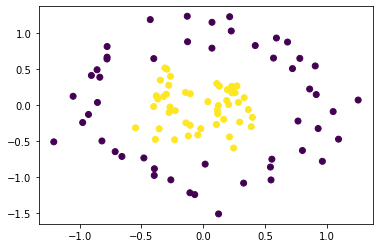

In [13]:
# 這個... 直線分不了欸
X, y = make_circles(100, factor=.3, noise=.15, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [14]:
# 點 X 和 center 的距離越遠, 得到的值越小
def rbf(center):
    return np.exp(-((X - center)**2).sum(1))

# all combs of rbf(x_i, x_j)
new_ax = np.array([rbf(p) for p in X])

# 每個 dataframe 是原始資料 + 新的 dimension 由 data point i 當成 center 算 rbf 值
new_X = [pd.DataFrame(
                np.concatenate((X, new_ax[i].reshape(-1, 1), y.reshape(-1, 1)), axis=1),
                columns=['x1', 'x2', 'rbf', 'label']) for i in range(len(new_ax))]
display(new_X[0].head(7))

,x1,x2,rbf,label
0,-0.928306,-0.129529,1.000000,0.0
1,0.165184,-0.197669,0.301085,1.0
2,0.913933,0.146873,0.031110,0.0
3,0.189661,0.065223,0.275883,1.0
4,-0.401253,-0.019918,0.748414,1.0
5,0.284197,0.037521,0.223561,1.0
6,-0.400129,0.645976,0.414626,0.0


In [15]:
# 試試以每個 data point 來當中心，看看哪個投影後能最好地線性分割

all_possible_trans = np.array([soft_margin(C=0.01, data=data) for data in new_X])
best_model_arg = np.argmin(all_possible_trans[:, -1])
best_model_info = all_possible_trans[best_model_arg]

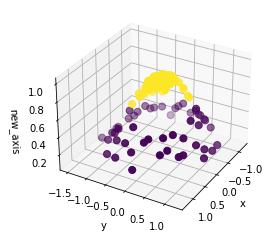

In [16]:
def plot_3D(elev=30, azim=30, X=X, y=y, wb=None):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('new_axis')
    plt.show()

# 看來以黃色圓中心附近為中心投影後，可以用一個平面線性分割出來
# 投影回原來的二維空間，decision boundary 似一個圈圈
plot_3D(X=new_X[best_model_arg].values[:, :3], y=y)

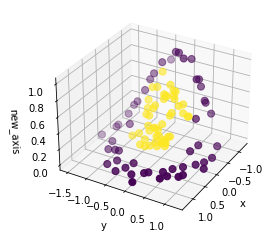

In [17]:
# 而其他任意一點為中心並不見得能做到
plot_3D(X=new_X[0].values[:, :3], y=y)

上述例子好像只有在特定情況下才能解決 <br>
如果說資料如下呢？

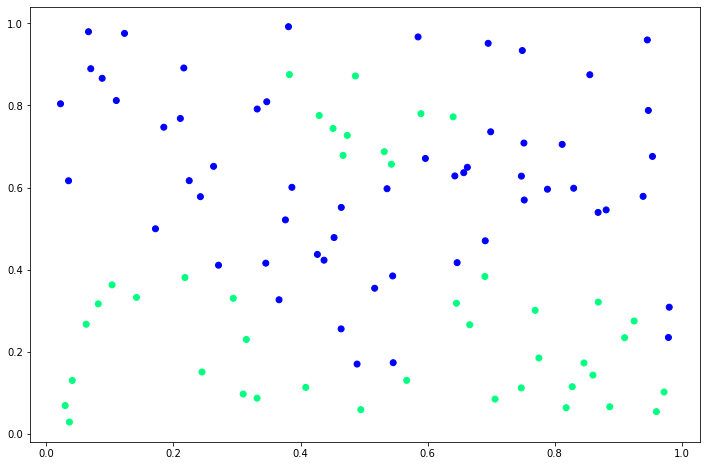

In [18]:
data_points = np.random.uniform(0, 1, (100, 2))
y = [1. if ((p - np.array([0.5, 0.8]))**2).sum() < 0.15**2 \
       or p[1] < np.sin(10 * p[0])/5 + 0.3
       else -1. for p in data_points]
plt.figure(figsize=(12, 8))
plt.scatter(data_points[:, 0], data_points[:, 1], c=y, cmap='winter')
plt.show()

In [19]:
data = pd.DataFrame(data_points, columns=['x1', 'x2'])
data['label'] = y
data.head()

,x1,x2,label
0,0.331781,0.791373,-1.0
1,0.536173,0.597227,-1.0
2,0.788699,0.595999,-1.0
3,0.979174,0.234884,-1.0
4,0.910140,0.234350,1.0


In [20]:
def rbf(x1, x2):
    return np.exp(-((x1 - x2)**2).sum(-1))

def get_b(kkt, K, C):
    y = data.label.values
    # 是 support vector 而且 分類正確
    intermediate_kkt_idx = np.where(kkt > 1e-6)[0]
    y_sv = y[intermediate_kkt_idx]
    intermediate_kkt = kkt[intermediate_kkt_idx]
    #                kx1  kx1  kxk
    return (y_sv - ((intermediate_kkt * y_sv) @ K[np.ix_(intermediate_kkt_idx, intermediate_kkt_idx)])).mean()

def project(X, kkt, b):
    y = data.label.values
    x = data.drop('label', axis=1).values

    # 是 support vector 而且 分類正確
    intermediate_kkt_idx = np.where(kkt > 1e-6)[0]
    y_sv = y[intermediate_kkt_idx]
    x_sv = x[intermediate_kkt_idx]
    intermediate_kkt = kkt[intermediate_kkt_idx]

    scores = np.array([np.sum(intermediate_kkt * y_sv * rbf(X[i], x_sv)) for i in range(X.shape[0])])
    return scores + b

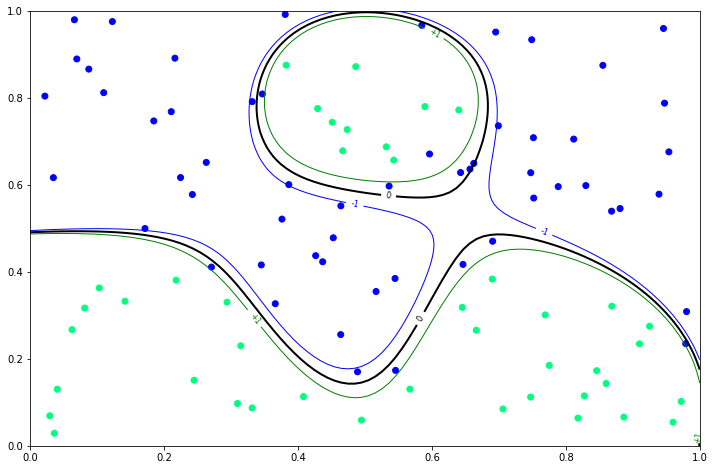

In [21]:
plt.figure(figsize=(12, 8))
plt.scatter(data_points[:, 0], data_points[:, 1], c=y, cmap='winter')
X, Y = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
X_grid, Y_grid = np.meshgrid(X, Y)

XY = np.c_[np.ravel(X_grid), np.ravel(Y_grid)]

# 換入了 rbf kernel
multiplier, K = find_kkt_multiplier(data, C=1000000, kernel='rbf')
b = get_b(multiplier, K, C)
Z = project(XY, multiplier, b).reshape(X_grid.shape)

H = plt.contour(X_grid, Y_grid, Z, [0.0], colors='k', linewidths=2)
H_1= plt.contour(X_grid, Y_grid, Z + 1, [0.0],colors='blue', linewidths=1)
H1 = plt.contour(X_grid, Y_grid, Z - 1, [0.0], colors='green', linewidths=1)

plt.clabel(H, inline=True, fmt="0", fontsize=8)
plt.clabel(H_1, inline=True, fmt="-1", fontsize=8)
plt.clabel(H1, inline=True, fmt="+1", fontsize=8)
plt.show()

In [22]:
house_price_data = DataLoader.load_data('iowa_original')

In [23]:
data = house_price_data[['GrLivArea', 'SalePrice']].iloc[:50]
x, y = data.values[:, 0], data.values[:, 1]

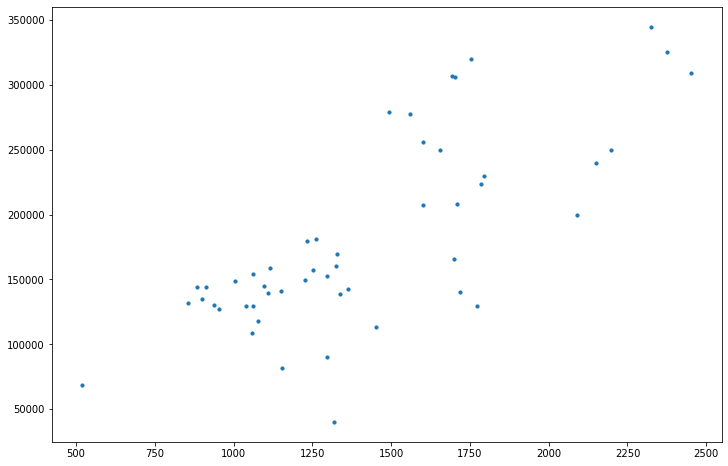

In [24]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y, s=10)
plt.show()

upper line: $ y = wx + b + \epsilon$ <br>
lower line: $ y = wx + b - \epsilon$ <br>
$ y - (wx + b) <= \epsilon + s $ <br>
$ (wx + b) - y <= \epsilon + s' $

In [25]:
model, params = model_setup(data)
params_name = params.keys()

C, e = .1, 50000
slacks_upper = model.addVars(range(len(data)))
slacks_lower = model.addVars(range(len(data)))

coefs = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values]
y = data.SalePrice.values

model.addConstrs(y[i] - (params.prod(coefs[i]) + params['b']) <= e + slacks_upper[i] for i in range(len(coefs)))
model.addConstrs((params.prod(coefs[i]) + params['b']) - y[i] <= e + slacks_lower[i] for i in range(len(coefs)))
c_part = C * gurobipy.quicksum(slacks_upper[i] + slacks_lower[i] for i in range(len(slacks_upper)))
sq_sum = gurobipy.quicksum(params[x]**2 for x in params_name[:-1])
model.setObjective(c_part + sq_sum, gurobipy.GRB.MINIMIZE)
model.optimize()

wb = [v.x for v in params.values()]
w, b = wb[:-1], wb[-1]

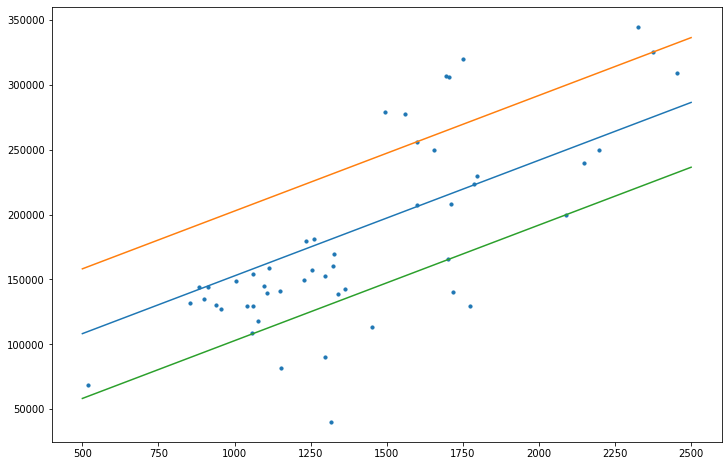

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, s=10)
X = np.linspace(500, 2500, 300)
Y = np.array([w[0] * x + b for x in X])
ax.plot(X, Y, '-')
ax.plot(X, Y+e, '-')
ax.plot(X, Y-e, '-')

plt.show()